# Importing libraries

In [20]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Lambda
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import random

from collections import defaultdict

# Set random seed

In [21]:
# Set environment variables
os.environ['PYTHONHASHSEED'] = str(25)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Set seed values
np.random.seed(25)
tf.random.set_seed(25)
random.seed(25)

# TODO: Preprocess

In [22]:
# Preprocess the text
def preprocess(text):
    # TODO
    words = text.lower().split()
    return words


# TODO: Build Vocabulary and training data

In [23]:
# TODO: Build vocabulary and generate training data
def build_and_prepare_data(words, window_size=2):
    # Build vocabulary
    word_counts = defaultdict(int)
    for word in words:
        word_counts[word] += 1
    vocab = {word: idx for idx, (word, _) in enumerate(word_counts.items())}

    # Generate context-target pairs
    contexts = []
    targets = []

    # Extract contexts and targets from data
    for idx, word in enumerate(words):
        context = []
        for i in range(-window_size, window_size + 1):
            if i != 0 and 0 <= idx + i < len(words):
                context.append(words[idx + i])
        if len(context) == 2 * window_size:
            contexts.append(context)
            targets.append(word)
    contexts = [[vocab[word] for word in context] for context in contexts]
    targets = [vocab[word] for word in targets]
    # Prepare contexts and targets for training by padding and one-hot encoding
    contexts = pad_sequences(contexts, maxlen=2 * window_size, padding='post')
    targets = to_categorical(targets, num_classes=len(vocab))
    return vocab, contexts, targets

# TODO: Build CBOW model

In [24]:
# Define CBOW model function
def build_cbow_model(vocab_size, embed_size, window_size):
    # TODO
    input_layer = Input(shape=(window_size * 2,))
    embedding = Embedding(vocab_size, embed_size, input_length=window_size*2)(input_layer)
    hidden = Lambda(lambda x: K.mean(x, axis=1))(embedding)
    output = Dense(vocab_size, activation='softmax')(hidden)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model

# TODO: Set file path

In [25]:
# TODO: set correct file path
file_path = './small_corpus.txt'

# Running the helper functions

In [26]:
# Read the file
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

words = preprocess(text)

# Print vocabulary size
print(f"Number of words: {len(words)}")

# Model parameters
window_size = 2

# Prepare dataset
vocab, contexts, targets = build_and_prepare_data(words, window_size)

vocab_size = len(vocab)
# Print vocabulary size
print(f"Vocabulary size: {vocab_size}")

# Print lengths of contexts and targets
print(f"Length of contexts array: {len(contexts)}")
print(f"Length of targets array: {len(targets)}")

Number of words: 280000
Vocabulary size: 28
Length of contexts array: 279996
Length of targets array: 279996


# Split the data inton training and validation sets

In [27]:
# Splitting the data
contexts_train, contexts_val, targets_train, targets_val = train_test_split(contexts, targets, test_size=0.2, random_state=25)

embed_size = 2

# Train the model

In [28]:
# Create and train the model
model = build_cbow_model(vocab_size, embed_size, window_size)
print(model.summary())
history = model.fit(contexts_train, targets_train, validation_data=(contexts_val, targets_val), epochs=7, verbose=1)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 embedding_1 (Embedding)     (None, 4, 2)              56        
                                                                 
 lambda_1 (Lambda)           (None, 2)                 0         
                                                                 
 dense_1 (Dense)             (None, 28)                84        
                                                                 
Total params: 140 (560.00 Byte)
Trainable params: 140 (560.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/7
7000/7000 [==============================] - 3s 393us/step - loss: 2.3511 - val_loss: 2.2244
Epoch 2/7
7000/7000 [========================

# TODO: Visualise the Training and Validation loss

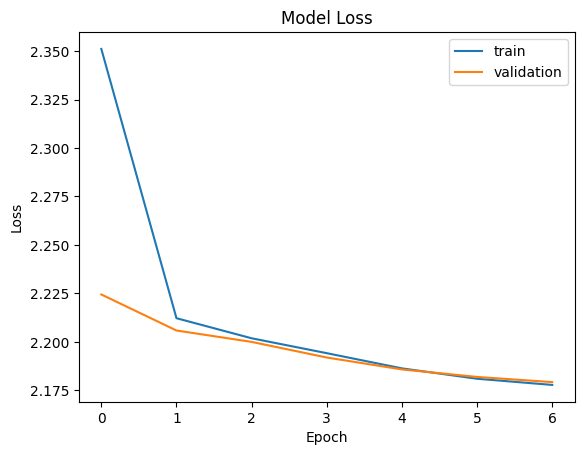

In [29]:
# Plotting the training and validation loss
#TODO
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# TODO: Extract the embeddings

In [30]:
# Extract embeddings
#TODO
embeddings = model.layers[1].get_weights()[0]

# TODO: Find similar words

In [31]:
def cosine_similarity(vec_a, vec_b):
    """Calculate the cosine similarity between two vectors."""
    #TODO
    dot_product = np.dot(vec_a, vec_b)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

def find_similar_words(query_word, vocab, embeddings, top_n=3):
    """Find the top_n words most similar to the query_word based on the embeddings."""
    similarities = []

    #TODO populate the similarities list
    query_idx = vocab[query_word]
    query_vec = embeddings[query_idx]
    similarities = []
    for word, idx in vocab.items():
        if word != query_word:
            word_vec = embeddings[idx]
            sim = cosine_similarity(query_vec, word_vec)
            similarities.append((word, sim))

    # Sort based on similarity scores
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Print top similar words
    print(f"Words most similar to '{query_word}':")
    for word, similarity in similarities[:top_n]:
        print(f"{word}: {similarity:.4f}")
    


In [32]:
query_words = ['poland', 'thailand', 'morocco']

for query_word in query_words:
    find_similar_words(query_word, vocab, embeddings)
    print("\n")


Words most similar to 'poland':
uk: 1.0000
france: 0.9996
switzerland: 0.9996


Words most similar to 'thailand':
bangladesh: 0.9864
china: 0.9735
japan: 0.9691


Words most similar to 'morocco':
ethiopia: 0.9924
tanzania: 0.9882
uganda: 0.9766




# TODO: Visualise the embeddings

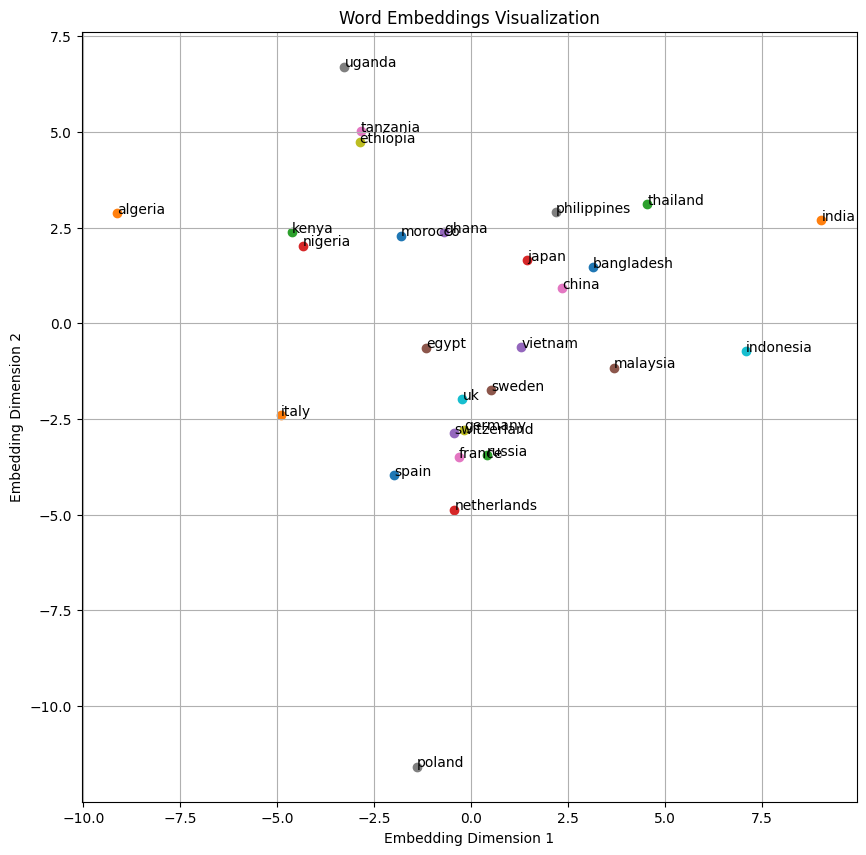

In [33]:
# Create a scatter plot of the embeddings
# TODO
plt.figure(figsize=(10, 10))
for word, idx in vocab.items():
    plt.scatter(embeddings[idx, 0], embeddings[idx, 1], label=word) 
    plt.annotate(word, (embeddings[idx, 0], embeddings[idx, 1]))  

plt.xlabel('Embedding Dimension 1')  
plt.ylabel('Embedding Dimension 2')  
plt.title('Word Embeddings Visualization')  
plt.grid(True)
plt.show()